# Florence2 + SAM2 Inference

In [1]:
# - Packages
import numpy as np
import torch
import cv2
import os

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from torch.utils.data import Dataset, DataLoader

import torch
import supervision as sv

from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)

import numpy as np
import torch
import cv2
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes
from tqdm import tqdm

In [2]:
# - Global Variables
## - Florence2
data_dir= Path("./snemi/" )
raw_image_dir = data_dir / 'image_pngs'
seg_image_dir = data_dir / 'seg_pngs'
test_image_dir = data_dir / 'image_test_pngs'


CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

label_num = 170

## - Define Dataloader
BATCH_SIZE = 5
NUM_WORKERS = 0

checkpoint_dir = './model_checkpoints/epoch_1000'

## - SAM2

data_dir= Path("./snemi/" )
raw_image_dir = data_dir / 'image_pngs'
seg_image_dir = data_dir / 'seg_pngs'
test_image_dir = data_dir / 'image_test_pngs'
sam2_checkpoint = "./sam2_hiera_large.pt"
model_cfg = "./sam2_hiera_l.yaml"
overlapp_ratio = 0.15
finetuned_parameter_path = "./checkpoints/large_model8163.torch"

In [3]:
# - Load Models
model = AutoModelForCausalLM.from_pretrained(checkpoint_dir, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(checkpoint_dir, trust_remote_code=True)
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=DEVICE)
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(finetuned_parameter_path))

<All keys matched successfully>

## Data Preparation

In [4]:
all_files = np.sort(os.listdir(test_image_dir))
test_image_path_lst = np.array([data_dir / test_image_path for test_image_path in all_files])

## Florence2 and Sam2 Inference

### Florence2 Inference

In [5]:
# - Define Florence Inference
def flo_infer_bboxes(image_path, max_new_tokens):
    max_labels = 0
    max_bboxes = []
    max_image = []
    for i in range(10):
        image = cv2.imread(str(image_path))
        image = Image.fromarray(image)
        task = "<OD>"
        text = "<OD>"
        inputs = processor(
            text=text, 
            images=image, 
            return_tensors="pt"
        ).to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=max_new_tokens,
            num_beams=3)
        generated_text = processor.batch_decode(
            generated_ids, skip_special_tokens=False)[0]
        response = processor.post_process_generation(
            generated_text, 
            task=task, 
            image_size=image.size)
        detections = sv.Detections.from_lmm(
            sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

        bounding_box_annotator = sv.BoxAnnotator(
            color_lookup=sv.ColorLookup.INDEX)
        label_annotator = sv.LabelAnnotator(
            color_lookup=sv.ColorLookup.INDEX)

        image = bounding_box_annotator.annotate(image, detections)
        image = label_annotator.annotate(image, detections)
        if len(response['<OD>']['bboxes']) > max_labels:
            max_labels = len(response['<OD>']['bboxes'])
            max_bboxes = response['<OD>']['bboxes']
            max_image = image
    plt.imshow(max_image)
    return max_labels, max_bboxes, max_image

### SAM2 Inference

In [6]:
def predict_seg(mode:str, img:np.ndarray, input_points: np.ndarray, point_labels: np.ndarray, input_boxes = None):
    torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
    if mode == "points":
        with torch.no_grad(): # prevent the net from caclulate gradient (more efficient inference)
            predictor.set_image(img) # image encoder
            masks, scores, logits = predictor.predict(  # prompt encoder + mask decoder
                point_coords=input_points,
                point_labels=point_labels,
                box = input_boxes,
                multimask_output=False)
    elif mode == 'boxes':
        with torch.no_grad(): # prevent the net from caclulate gradient (more efficient inference)
            predictor.set_image(img) # image encoder
            masks, scores, logits = predictor.predict(  # prompt encoder + mask decoder
                point_coords=None,
                point_labels=None,
                multimask_output=False,
                box = input_boxes)
    else:
        print('Not Valid Mode')
        return None
            
    # - sort masks based on their scores (high-quality segmentation)
    masks=masks[:,0].astype(bool)
    shorted_masks = masks[np.argsort(scores[:,0])][::-1].astype(bool)
     # - create an empty segmentation map
    seg_map = np.zeros_like(shorted_masks[0],dtype=np.uint8)
    occupancy_mask = np.zeros_like(shorted_masks[0],dtype=bool)

    # - add the masks one by one from high to low score
    for i in range(shorted_masks.shape[0]):
        mask = shorted_masks[i]
        if (mask*occupancy_mask).sum()/mask.sum()>overlapp_ratio: continue 
        mask[occupancy_mask]=0
        seg_map[mask]=i+1
        occupancy_mask[mask]=1
        
    # - project back to RGB
    rgb_image = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
    for id_class in range(1,seg_map.max()+1):
        rgb_image[seg_map == id_class] = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

    plt.figure(figsize=(20, 20))

    # First image (annotation)
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
    plt.imshow(rgb_image)
    plt.title('Annotation')
    plt.axis('off')  # Hide the axis

    # Second image (mix)
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
    mix_image = (rgb_image / 2 + img / 2).astype(np.uint8)
    plt.imshow(mix_image)
    plt.title('Mix')
    plt.axis('off')

    # Third image (original image)
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.tight_layout()  # Adjust the layout so everything fits without overlap
    plt.show()

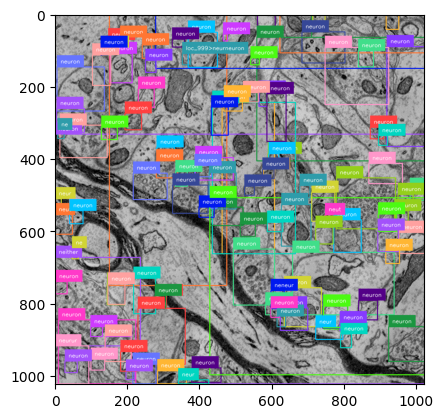

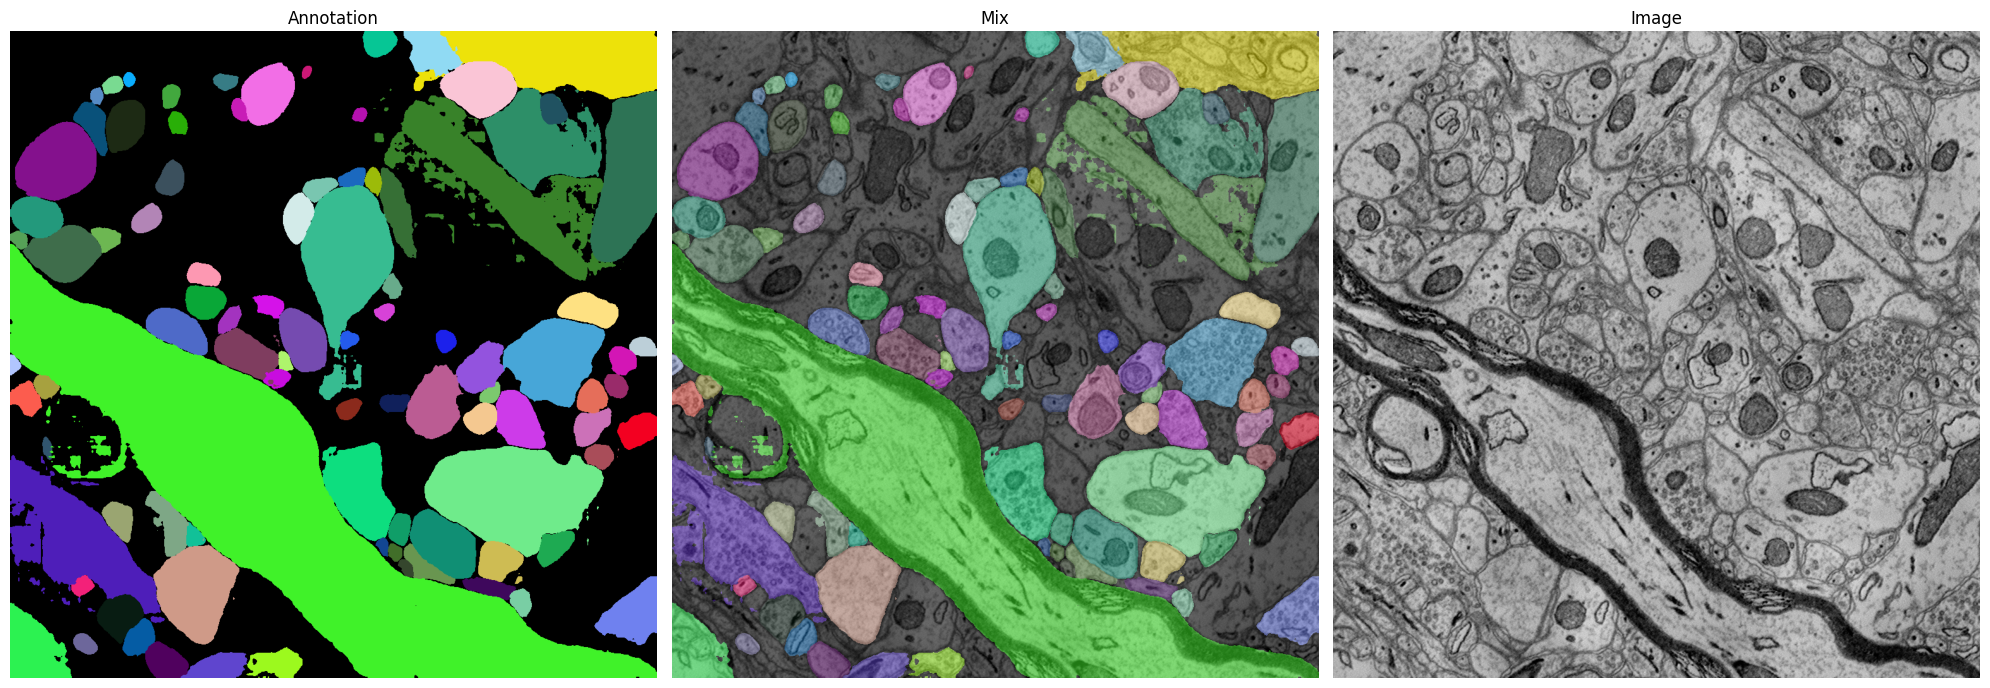

In [7]:
# - Florence2 + SAM2 Test Sample Image: only bboxes
image_path = test_image_dir / 'image0000.png'
num_labels, bboxes, image = flo_infer_bboxes(image_path, 2048)
image = cv2.imread(str(image_path))
predict_seg('boxes', image , None, None, input_boxes = bboxes)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.30 GiB. GPU 1 has a total capacity of 23.67 GiB of which 1.22 GiB is free. Process 431054 has 1.74 GiB memory in use. Process 443898 has 3.31 GiB memory in use. Including non-PyTorch memory, this process has 16.65 GiB memory in use. Of the allocated memory 13.94 GiB is allocated by PyTorch, and 2.46 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

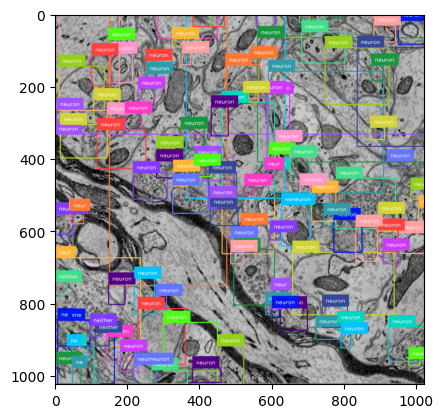

In [8]:
# - Florence2 + SAM2 Test Sample Image: Bounding Box + Points
valid_input_points_lst = []
for i in range(3):
    valid_input_points_lst.append(np.array([[np.random.uniform(box[0], box[2]), np.random.uniform(box[1], box[3])] for box in bboxes]))    
valid_input_points_lst = np.array(valid_input_points_lst)
valid_input_points_lst = valid_input_points_lst.reshape(valid_input_points_lst.shape[0] * valid_input_points_lst.shape[1], 1, valid_input_points_lst.shape[2])
image_path = test_image_dir / 'image0000.png'
num_labels, bboxes, image = flo_infer_bboxes(image_path, 2048)
image = cv2.imread(str(image_path))
predict_seg('points', image, valid_input_points_lst, np.ones([valid_input_points_lst.shape[0], 1]))